In [1]:
## notebookの表示領域広げる
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## 描画できるようにする＆綺麗に描画できるようにする
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

## 自動で時間表示する
%load_ext autotime

## ライブラリのリロードを行えるようにする
%load_ext autoreload

import pandas as pd
import numpy as np

## dataframeの表示を広げる
def disp_full(x, drows=False, dcols=True):
    if drows:
        pd.set_option('display.max_rows', x.shape[0])
    if dcols:
        pd.set_option('display.max_columns', x.shape[1])
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [2]:
import os, sys, gc

time: 766 µs


In [3]:
import seaborn as sns

time: 385 ms


In [4]:
from tqdm import tqdm_notebook as tqdm

time: 7.84 ms


In [5]:
from sklearn.metrics import roc_auc_score

time: 298 ms


In [6]:
import lightgbm as lgb

time: 21.7 ms


In [7]:
import shap
shap.initjs()

time: 1.01 s


## make datasets

In [8]:
corr_mat = pd.read_pickle('../data/processed/113/1/corr_mat.pickle')

time: 11.1 ms


In [9]:
feature_set = [[110, 1], [111, 1], [112, 1]]

X_train = pd.concat([pd.read_pickle(f'../data/processed/{_feature_num}/{_version}/train.pickle') for _feature_num, _version in feature_set], axis=1)
y_train = pd.read_pickle('../data/processed/000/train.pickle').set_index('ID_code').loc[X_train.index, 'target']

real_id = pd.read_pickle('../data/processed/001/real_id.pickle')
X_test = pd.concat([pd.read_pickle(f'../data/processed/{_feature_num}/{_version}/test.pickle') for _feature_num, _version in feature_set], axis=1)[X_train.columns]
X_test = X_test.loc[real_id]

/home/takuya.akiyama/.pyenv/versions/anaconda3-2018.12/envs/kaggle1/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



time: 31.9 s


In [10]:
X_train.shape

(200000, 1000)

time: 3.71 ms


In [11]:
X_test.shape

(100000, 1000)

time: 3.55 ms


## train and predict

In [12]:
from sklearn.model_selection import StratifiedKFold

time: 1.56 ms


In [13]:
params = {
    'bagging_freq': 5,
    'bagging_fraction': 0.9,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1.0,
    'learning_rate': 0.05,
    'max_depth': -1,
    'metric':'binary_logloss',
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 4,
    'num_threads': 32,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1}

oof_pred_array = np.ones((200000, 200))
test_pred_array = np.ones((100000, 5, 200))
for cnum in range(200):
    #collist = corr_mat.loc[corr_mat[f'var_{cnum}'] > 0.98, f'var_{cnum}'].sort_values(ascending=False).index.tolist()
    collist = corr_mat[f'var_{cnum}'].sort_values(ascending=False)[:5].index.tolist()
    print(f'cnum:{cnum}\tsimilar col:{collist}')

    skf = StratifiedKFold(n_splits=5)
    #folds = [[np.concatenate([_trn+i * X_train.shape[0] for i in range(len(collist))]), np.concatenate([np.array(_val) for i in range(len(collist))])] for _trn, _val in skf.split(X_train, y_train)]
    folds = [[np.concatenate([_trn+i * X_train.shape[0] for i in range(len(collist))]), np.array(_val)] for _trn, _val in skf.split(X_train, y_train)]
    train_dset = lgb.Dataset(
        np.concatenate([X_train.filter(regex=f'{c}$').values for c in collist], axis=0), 
        np.concatenate([y_train for c in range(len(collist))], axis=0), free_raw_data=False, 
        weight=np.concatenate([np.ones((X_train.shape[0]))*len(collist), np.ones((X_train.shape[0]*(len(collist)-1)))])
    )
    cv_result, bsts = lgb.cv(params, train_set=train_dset, num_boost_round=100000, early_stopping_rounds=100, 
                             folds=folds)

    best_iteration = bsts.best_iteration
    for i, bst in enumerate(bsts.boosters):
        # oofの予測
        cv_valid_index = bst.valid_sets[0].used_indices
        #cv_valid_index = cv_valid_index[:int(cv_valid_index.shape[0]/len(collist))]
        cv_valid_data = X_train.filter(regex=f'var_{cnum}$').iloc[cv_valid_index].values
        oof_pred_array[cv_valid_index, cnum] = bst.predict(cv_valid_data, num_iteration=best_iteration)
        # testの予測
        test_pred_array[:, i, cnum] = bst.predict(X_test.filter(regex=f'var_{cnum}$'), num_iteration=best_iteration)
    print('\tauc : {0:.6f}'.format(roc_auc_score(y_train, oof_pred_array[:, cnum])))
    print('\tauc : {0:.6f}'.format(roc_auc_score(y_train, oof_pred_array.prod(axis=1))))

cnum:0	similar col:['var_0', 'var_110', 'var_44', 'var_174', 'var_76']
	auc : 0.547434
	auc : 0.547434
cnum:1	similar col:['var_1', 'var_78', 'var_43', 'var_145', 'var_109']
	auc : 0.545408
	auc : 0.573603
cnum:2	similar col:['var_2', 'var_191', 'var_0', 'var_163', 'var_44']
	auc : 0.552557
	auc : 0.596959
cnum:3	similar col:['var_3', 'var_154', 'var_83', 'var_75', 'var_55']
	auc : 0.509195
	auc : 0.598310
cnum:4	similar col:['var_4', 'var_173', 'var_35', 'var_188', 'var_156']
	auc : 0.508491
	auc : 0.598765
cnum:5	similar col:['var_5', 'var_34', 'var_109', 'var_145', 'var_1']
	auc : 0.530427
	auc : 0.608224
cnum:6	similar col:['var_6', 'var_157', 'var_106', 'var_111', 'var_147']
	auc : 0.559686
	auc : 0.627853
cnum:7	similar col:['var_7', 'var_126', 'var_134', 'var_37', 'var_101']
	auc : 0.498367
	auc : 0.627376
cnum:8	similar col:['var_8', 'var_77', 'var_20', 'var_87', 'var_104']
	auc : 0.517787
	auc : 0.629602
cnum:9	similar col:['var_9', 'var_113', 'var_75', 'var_83', 'var_55']
	au

	auc : 0.542756
	auc : 0.796640
cnum:79	similar col:['var_79', 'var_9', 'var_55', 'var_113', 'var_83']
	auc : 0.503869
	auc : 0.796580
cnum:80	similar col:['var_80', 'var_76', 'var_174', 'var_155', 'var_0']
	auc : 0.558343
	auc : 0.802419
cnum:81	similar col:['var_81', 'var_148', 'var_190', 'var_122', 'var_135']
	auc : 0.572968
	auc : 0.810839
cnum:82	similar col:['var_82', 'var_187', 'var_188', 'var_90', 'var_128']
	auc : 0.521038
	auc : 0.812288
cnum:83	similar col:['var_83', 'var_75', 'var_9', 'var_55', 'var_113']
	auc : 0.519845
	auc : 0.813298
cnum:84	similar col:['var_84', 'var_48', 'var_118', 'var_116', 'var_23']
	auc : 0.510232
	auc : 0.813471
cnum:85	similar col:['var_85', 'var_194', 'var_90', 'var_121', 'var_92']
	auc : 0.520889
	auc : 0.814472
cnum:86	similar col:['var_86', 'var_198', 'var_162', 'var_26', 'var_157']
	auc : 0.538828
	auc : 0.817420
cnum:87	similar col:['var_87', 'var_173', 'var_156', 'var_178', 'var_52']
	auc : 0.536235
	auc : 0.818881
cnum:88	similar col:['v

	auc : 0.515694
	auc : 0.891313
cnum:157	similar col:['var_157', 'var_6', 'var_111', 'var_106', 'var_147']
	auc : 0.528775
	auc : 0.892198
cnum:158	similar col:['var_158', 'var_129', 'var_65', 'var_14', 'var_159']
	auc : 0.501853
	auc : 0.892198
cnum:159	similar col:['var_159', 'var_57', 'var_140', 'var_65', 'var_149']
	auc : 0.512591
	auc : 0.892299
cnum:160	similar col:['var_160', 'var_177', 'var_150', 'var_173', 'var_87']
	auc : 0.504927
	auc : 0.892332
cnum:161	similar col:['var_161', 'var_171', 'var_43', 'var_3', 'var_137']
	auc : 0.504964
	auc : 0.892297
cnum:162	similar col:['var_162', 'var_198', 'var_86', 'var_123', 'var_108']
	auc : 0.527965
	auc : 0.892963
cnum:163	similar col:['var_163', 'var_191', 'var_2', 'var_22', 'var_125']
	auc : 0.535279
	auc : 0.894010
cnum:164	similar col:['var_164', 'var_196', 'var_156', 'var_128', 'var_188']
	auc : 0.539578
	auc : 0.895439
cnum:165	similar col:['var_165', 'var_43', 'var_109', 'var_78', 'var_127']
	auc : 0.551495
	auc : 0.897448
cnu

In [14]:
cv_index_list = []
for i, bst in enumerate(bsts.boosters):
    train_index = bst.train_set.used_indices
    train_index = train_index[:int(train_index.shape[0]/len(collist))]
    valid_index = bst.valid_sets[0].used_indices
    cv_index_list.append([train_index, valid_index])

time: 1.75 ms


In [15]:
roc_auc_score(y_train, oof_pred_array.prod(axis=1))

0.920244738204284

time: 216 ms


In [16]:
roc_auc_score(y_train, (9 * oof_pred_array / (1 - oof_pred_array)).prod(axis=1))

0.9207698087422679

time: 279 ms


In [17]:
thr = 0.507
print(f'threashold : {thr}')
oof_pred_prod = np.ones((200000))
oof_pred_odds_prod = np.ones((200000))
test_pred_odds_prod = np.ones((100000, 5))
for cnum in tqdm(range(200)):
    tmp_auc = roc_auc_score(y_train, oof_pred_array[:, cnum])
    if tmp_auc >= thr:
        oof_pred_prod *= oof_pred_array[:, cnum]
        oof_pred_odds_prod *= 9 * oof_pred_array[:, cnum] / (1 - oof_pred_array[:, cnum])
        test_pred_odds_prod *= 9 * test_pred_array[:,:, cnum] / (1 - test_pred_array[:,:, cnum])
print('raw prod auc : {0:.6f}'.format(roc_auc_score(y_train, oof_pred_prod)))
print('odds prod auc : {0:.6f}'.format(roc_auc_score(y_train, oof_pred_odds_prod)))

threashold : 0.507



raw prod auc : 0.920736
odds prod auc : 0.921179
time: 22.1 s


In [18]:
model_number = 910
model_output_save_dir = f'../data/processed/{model_number}'
if not os.path.isdir(model_output_save_dir):
    os.makedirs(model_output_save_dir)

pd.DataFrame(oof_pred_array, index=X_train.index, columns=[f'pred_{i}' for i in range(200)])\
    .to_pickle(os.path.join(model_output_save_dir, 'oof_preds.pkl.gz'), compression='gzip')
pd.DataFrame(cv_index_list, columns=['train_index', 'valid_index'])\
    .to_pickle(os.path.join(model_output_save_dir, 'cv_index.pkl.gz'), compression='gzip')
pd.to_pickle(test_pred_array, os.path.join(model_output_save_dir, 'test_pred_array.pickle'))

time: 48.3 s


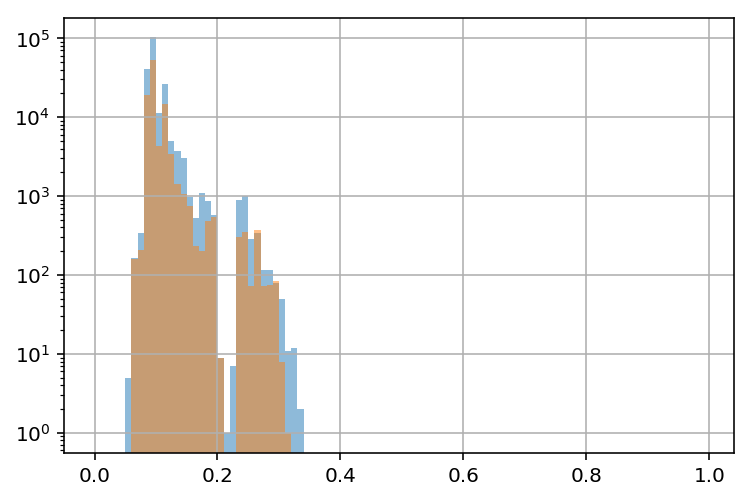

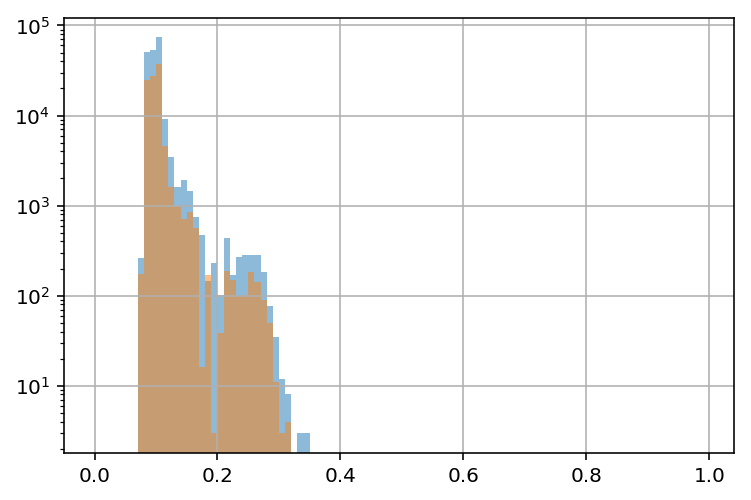

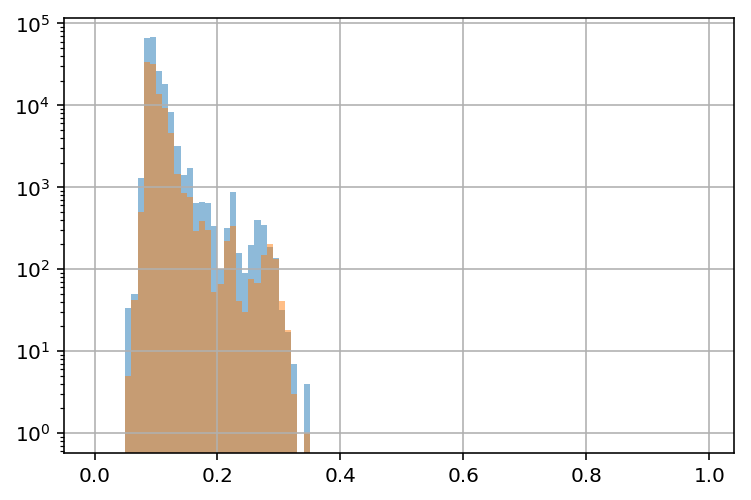

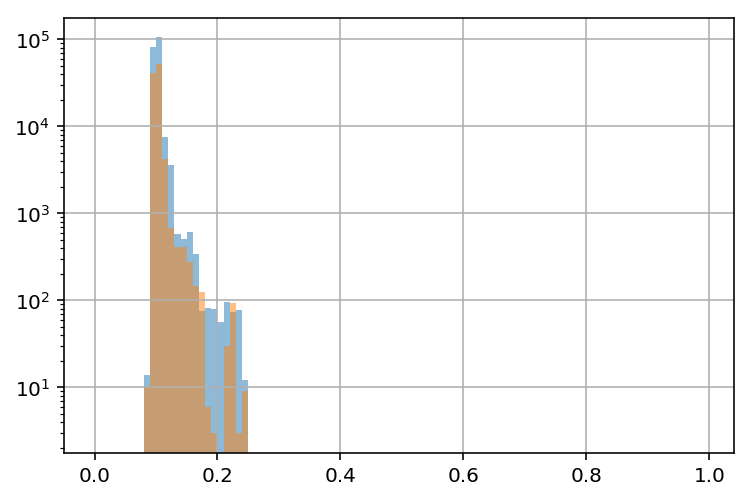

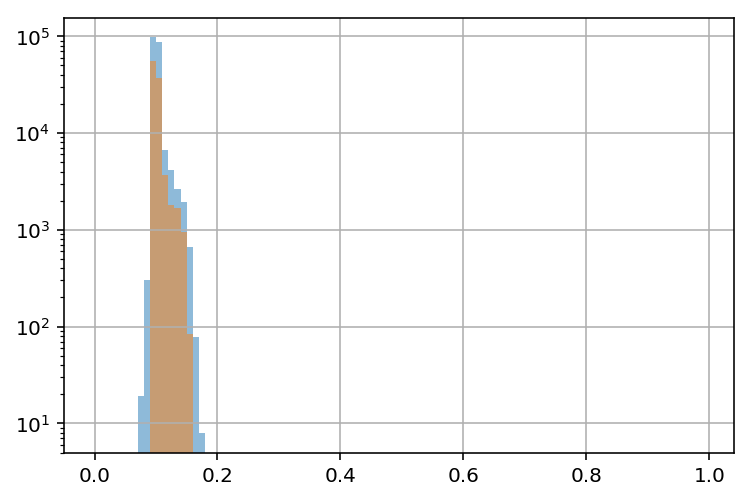

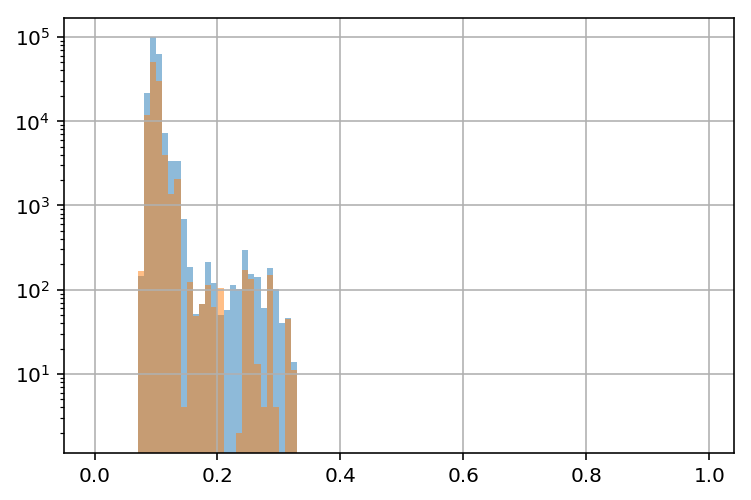

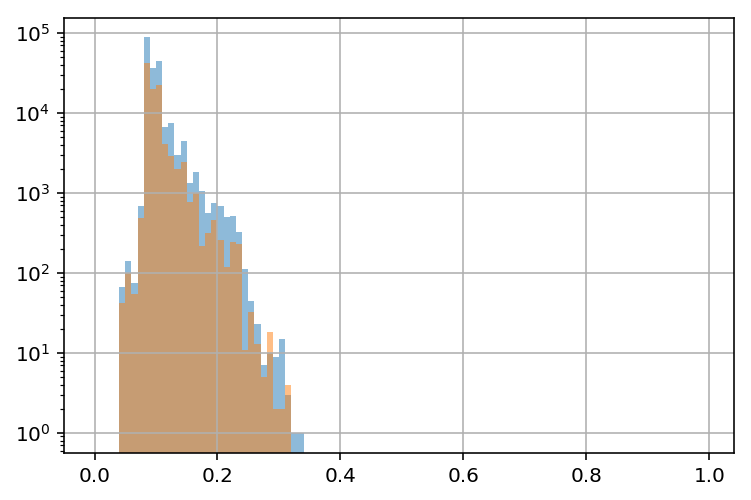

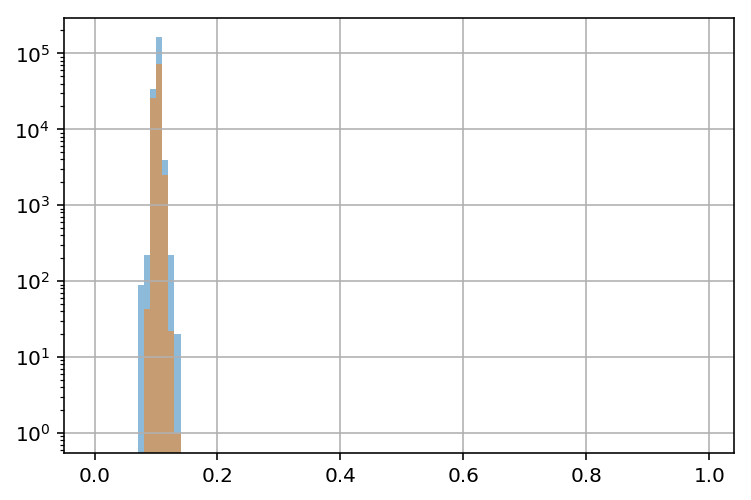

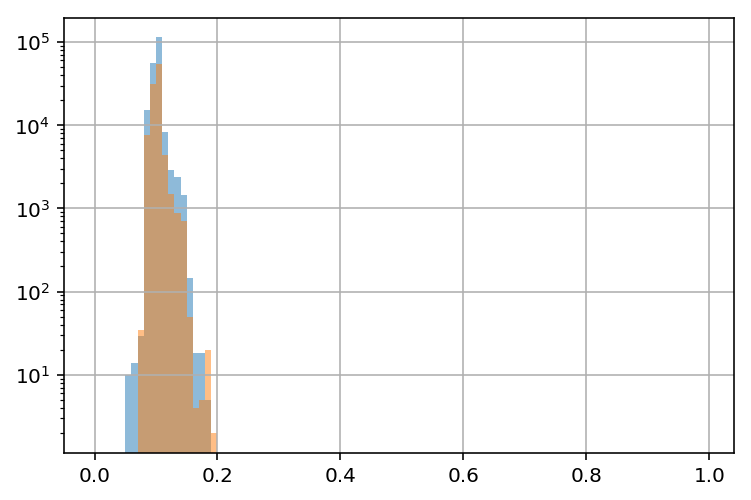

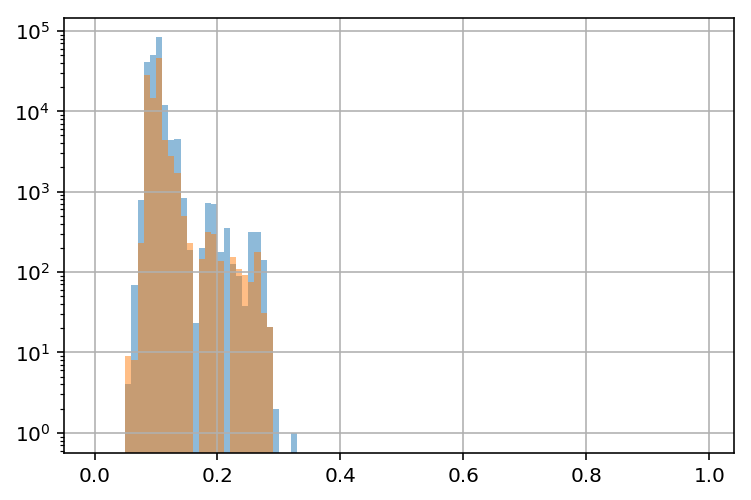

time: 10.4 s


In [19]:
for c in range(10):
    pd.Series(oof_pred_array[:, c]).hist(bins=np.arange(0, 1, 0.01), alpha=0.5)
    ax = pd.Series(test_pred_array[:, 0, c]).hist(bins=np.arange(0, 1, 0.01), alpha=0.5)
    ax.set_yscale('log')
    plt.show()

In [20]:
oof_pred = pd.DataFrame({'pred':oof_pred_odds_prod, 'label':y_train}, index=y_train.index)
test_pred = pd.DataFrame(test_pred_odds_prod, index=X_test.index, columns=[f'fold_{i}' for i in range(5)])

time: 10.7 ms


Text(0.5, 1.0, 'test prediction')

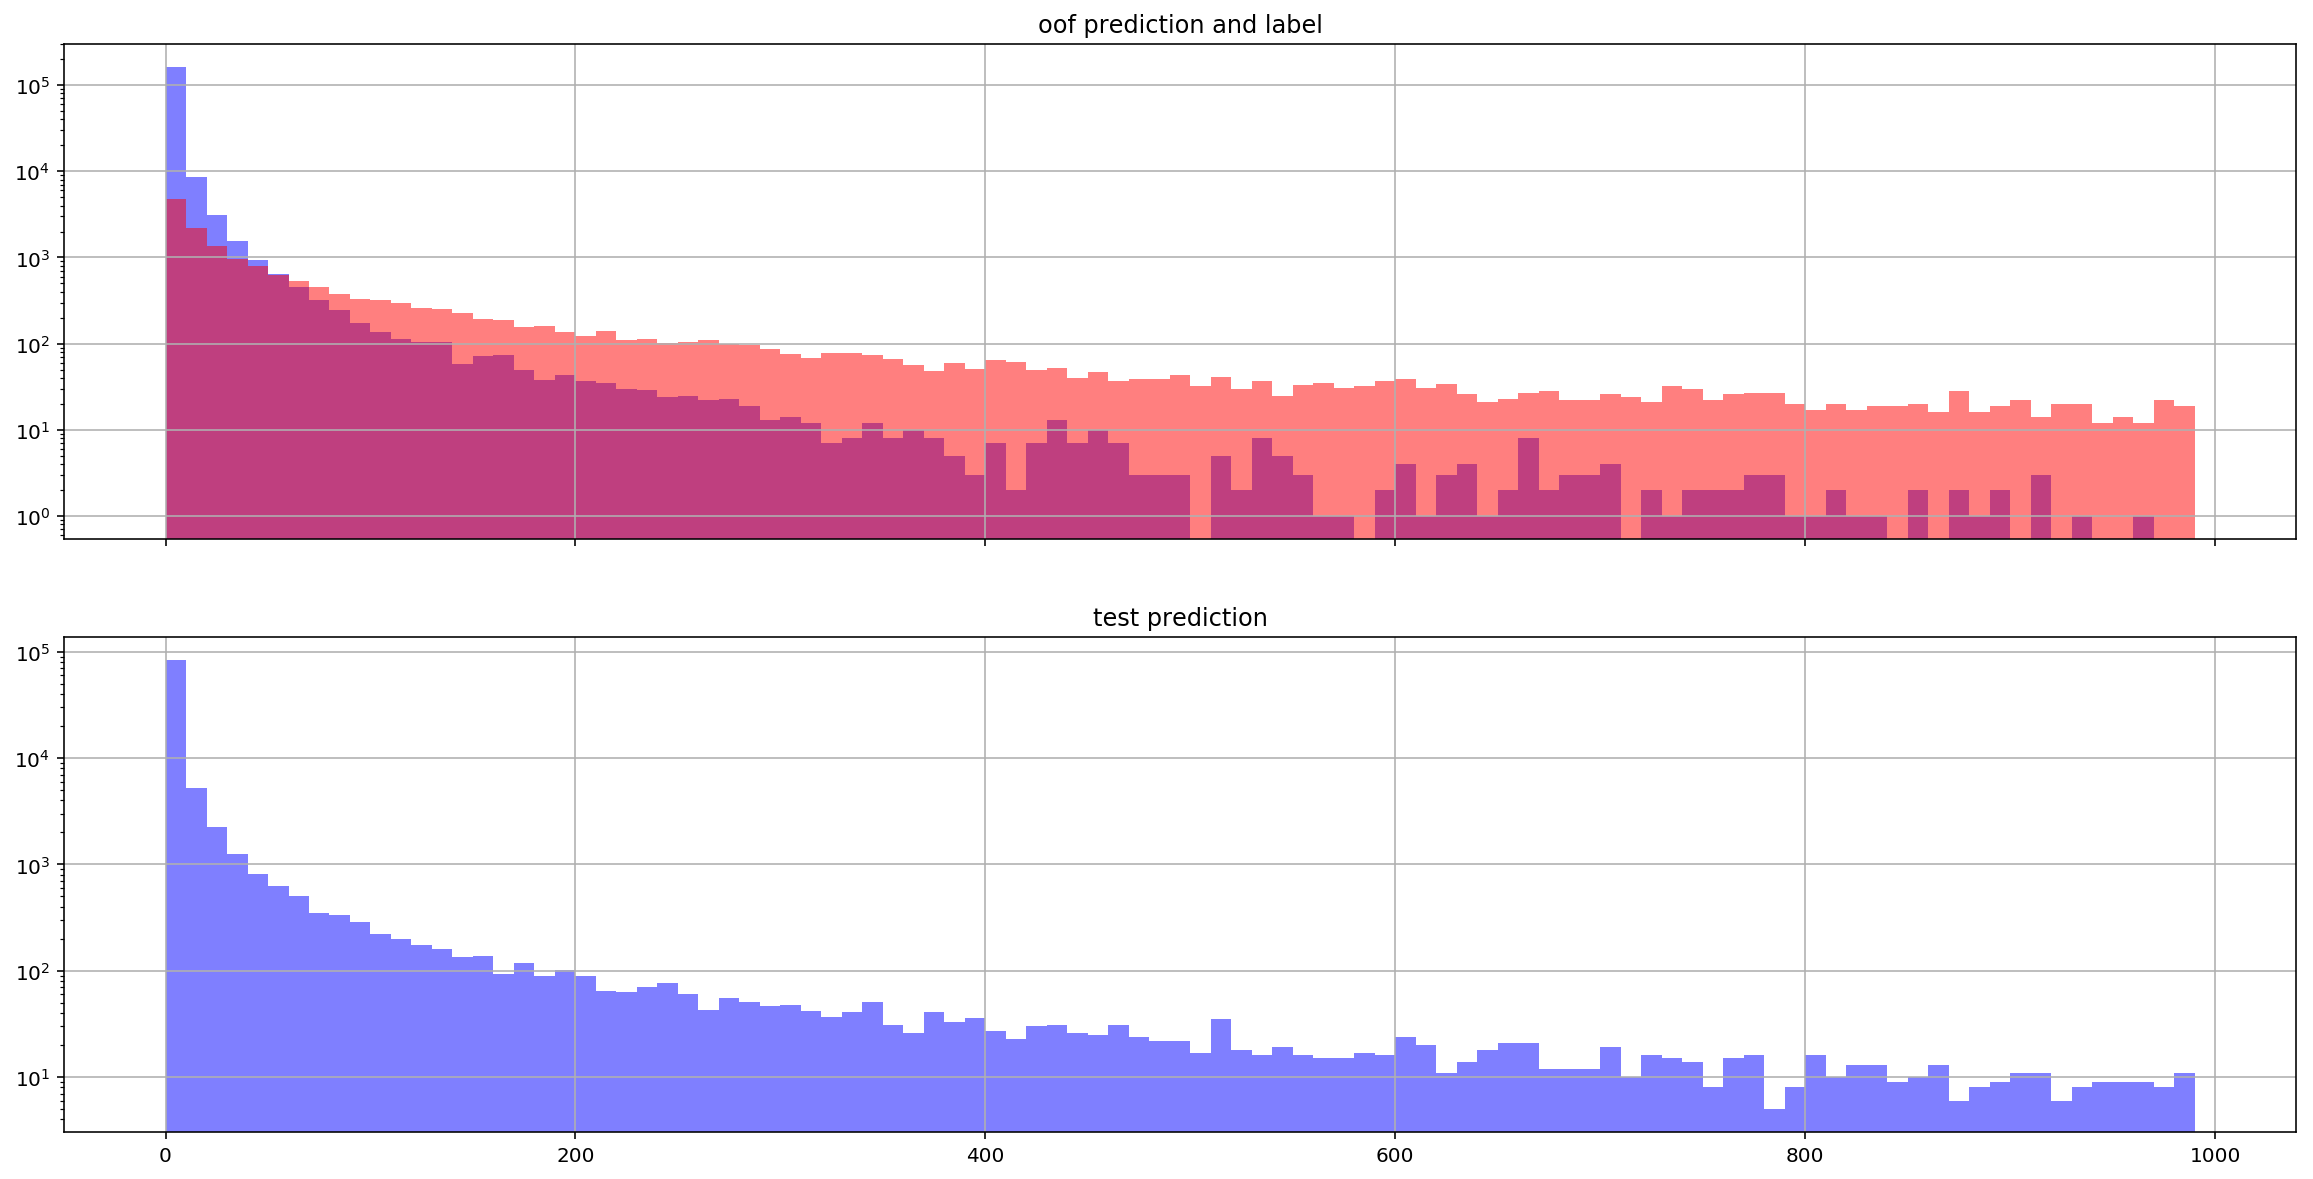

time: 2.41 s


In [21]:
bins=np.arange(0, 1000, 10) #np.arange(-0.1, 1.1, 0.01)

fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=True)
ax = axs[0]
oof_pred.query('label==0')['pred'].hist(bins = bins, ax=ax, color='b', alpha=0.5)
oof_pred.query('label==1')['pred'].hist(bins = bins, ax=ax, color='r', alpha=0.5)
ax.set_yscale('log')
ax.set_title('oof prediction and label')
ax = axs[1]
test_pred.mean(axis=1).hist(bins = bins, ax=ax, color='b', alpha=0.5)
ax.set_yscale('log')
ax.set_title('test prediction')

## submit

In [22]:
sub = pd.read_pickle('../data/processed/000/sample_submission.pickle')

time: 58.2 ms


In [23]:
sub = sub[['ID_code']].merge((test_pred.rank()/test_pred.shape[0]).mean(axis=1).reset_index(name='target')\
                             .rename(columns={'index':'ID_code'}), how='left').fillna(0)

time: 349 ms


In [24]:
sub.head()

,ID_code,target
0,test_0,0.000000
1,test_1,0.000000
2,test_2,0.000000
3,test_3,0.859428
4,test_4,0.000000


time: 11.2 ms


In [25]:
if not os.path.isdir('../data/out'):
    os.makedirs('../data/out')
sub.to_csv(f'../data/out/{model_number}_lgb.csv.gz', index=False, compression='gzip')

time: 1.44 s


In [27]:
pd.read_csv(f'../data/out/{model_number}_lgb.csv.gz').set_index('ID_code')['target'].corr(
    pd.read_csv('../data/out/904_lgb.csv.gz').set_index('ID_code')['target'], method='spearman')

0.9951170644497827

time: 424 ms


In [28]:
pd.read_csv(f'../data/out/{model_number}_lgb.csv.gz').set_index('ID_code')['target'].corr(
    pd.read_csv('../data/external/lgb_sub_hrd_0404_2.csv').set_index('ID_code')['target'], method='spearman')

0.9922740112583734

time: 400 ms


In [30]:
print(f'../data/out/{model_number}_lgb.csv.gz')

../data/out/910_lgb.csv.gz
time: 13.2 ms


In [31]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f ../data/out/910_lgb.csv.gz -m 'cv:0.921179'

100%|████████████████████████████████████████| 960k/960k [00:00<00:00, 3.77MB/s]
Successfully submitted to Santander Customer Transaction Predictiontime: 2.38 s


In [32]:
sub1 = pd.read_csv('../data/out/904_lgb.csv.gz')
sub2 = pd.read_csv('../data/out/910_lgb.csv.gz')

time: 370 ms


In [33]:
sub1.set_index('ID_code')['target'].corr(sub2.set_index('ID_code')['target'], method='spearman')

0.9951170644497827

time: 101 ms


In [39]:
rankave_sub = ((sub1.set_index('ID_code')['target'].rank()/2 + sub2.set_index('ID_code')['target'].rank()/2)/sub1.shape[0]).reset_index()

time: 99 ms


In [42]:
rankave_sub.to_csv(f'../data/out/rankave_904_910.csv.gz', index=False, compression='gzip')

time: 1.52 s


In [43]:
pd.read_csv(f'../data/out/rankave_904_910.csv.gz').set_index('ID_code')['target'].corr(
    pd.read_csv('../data/out/904_lgb.csv.gz').set_index('ID_code')['target'], method='spearman')

0.9987720324215111

time: 396 ms


In [44]:
pd.read_csv(f'../data/out/rankave_904_910.csv.gz').set_index('ID_code')['target'].corr(
    pd.read_csv('../data/out/910_lgb.csv.gz').set_index('ID_code')['target'], method='spearman')

0.9987719349881313

time: 388 ms


In [45]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f ../data/out/rankave_904_910.csv.gz -m 'no comment'

100%|████████████████████████████████████████| 897k/897k [00:00<00:00, 3.82MB/s]
Successfully submitted to Santander Customer Transaction Predictiontime: 4.2 s
